In [1]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import MiniBatchKMeans
from sklearn.datasets import make_classification
import pandas as pd
from numpy import unique
from matplotlib import pyplot
from numpy import where

In [2]:
from utils.FeatureExtract import process_img
import os
import cv2
import time
from threading import Thread

In [3]:
# Enable Debug Settings
debug_setting = False

def dprint(*arg, debug = debug_setting):
    if debug:
        try:
            print(arg)
        except Exception as e:
            print("Error:", e)
            
    

In [4]:
# load the input data
f = open('./E_sample.txt', 'r')
WIDTH = 320
HEIGHT = 320

#f = open('../house_64.txt','r')
content = f.readlines()
f.close()

In [5]:
# data pre-processing: time-access
x1 = []
y1 = []

x2 = []
y2 = []

x3 = []
y3 = []

x4 = []
y4 = []

for line in content:
    #print(line)
    time_str = ''
    start = False
    for char in line:
        if char == ']':
            break
        if start:
            time_str += char
        if char == '[':
            start = True
            
    #print(time_str)
    #print(line)
    # manual add range
    #if int(time_str) < 789000 or int(time_str)>791000:
    #    continue
    
    
    
    if "I" in line:  # line anchor
        x1.append(int(time_str))
        y1.append(1) 
        #print("1", int(time_str))
    if "O" in line:  # level 1 logic, every pixel should do once
        x2.append(int(time_str))
        y2.append(0.99)
        #print("2", int(time_str))
    if "K" in line:  # level 2 logic
        x3.append(int(time_str))
        y3.append(0.98)
    if "R" in line:
        x4.append(int(time_str))
        y4.append(0.97)

In [6]:
# basic statistics
# statistics
I_count = 0   # row level
O_count = 0   # pixel level
K_count = 0   # second level logic
R_count = 0   # third level logic



for line in content:
    if "I" in line:
        I_count += 1
    if "O" in line:
        O_count += 1
    if "K" in line:
        K_count += 1
    if "R" in line:
        R_count += 1
print(I_count, O_count, K_count, R_count)


340 106227 10151 514


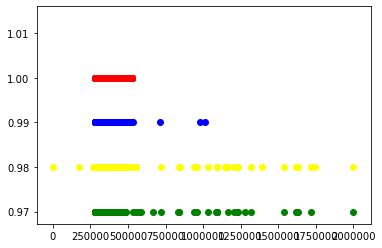

In [7]:
# check if the time pattern is there.
plt.scatter(x1, y1, color="red")
plt.scatter(x2, y2, color="blue")     
plt.scatter(x3, y3, color="yellow")    
plt.scatter(x4, y4, color="green")   
plt.show()

In [8]:
# try to handle it.
## get avg distance between red points.
avg_distance = 0
for i in range(1,len(x1)):
    avg_distance += x1[i] - x1[i-1]
avg_distance= avg_distance/len(x1)

print(avg_distance)

731.6676470588235


In [9]:
#preprocess x2, x3 and x4


#first corp the points that only fall into the x1 cycle.
processed_x1 = []
for i in range(1,len(x1)):
    if x1[i]-x1[i-1] < 2:
        pass
    else:
        processed_x1.append(x1[i-1])
        


processed_x2 = []
for i in range(1,len(x2)):
    if x2[i]-x2[i-1] < 2 or x2[i] < x1[0] or x2[i] > x1[-1]:
        pass
    else:
        processed_x2.append(x2[i-1])
        
processed_x3 = []
for i in range(1,len(x3)):
    if x3[i]-x3[i-1] < 4 or x3[i] < x1[0] or x3[i] > x1[-1]:
        pass
    else:
        processed_x3.append(x3[i-1])
        
processed_x4 = []
for i in range(1,len(x4)):
    if x4[i]-x4[i-1] < 4 or x4[i] < x1[0] or x4[i] > x1[-1]:
        pass
    else:
        processed_x4.append(x4[i-1])
        
print(len(processed_x1),len(processed_x2), len(processed_x3), len(processed_x4))

326 80660 1239 276


In [15]:
# now check the number of x2 points between each x1 (only for information)
x2_count_in_line = []
num_of_point = 0
x1_counter = 0
for p in processed_x2:
    if p<x1[x1_counter]:
        num_of_point += 1
    else:
        x2_count_in_line.append(num_of_point)
        num_of_point = 1
        x1_counter += 1
    if x1_counter >= len(x1):
        break
        
print(x2_count_in_line, len(x2_count_in_line))
new_x2_count = [x for x in x2_count_in_line if x > 10]
print(new_x2_count, len(new_x2_count))

x3_count_in_line = [0]*len(processed_x2)
x2_counter=0
x3_counter = 0
while True:
    p = processed_x3[x3_counter]
    #print(p, processed_x2[x2_counter])
    if p<=x2[x2_counter]:
        x3_count_in_line[x2_counter]+=1
        x3_counter += 1
    else:
        x2_counter += 1
    if x2_counter >= len(processed_x2) or x3_counter >= len(processed_x3):
        break
        

dprint(x3_count_in_line, len(x3_count_in_line))


[0, 1, 1, 1, 1, 1, 1, 320, 1, 287, 284, 280, 259, 283, 280, 265, 1, 279, 1, 283, 285, 100, 190, 2, 274, 274, 279, 280, 2, 294, 293, 290, 287, 286, 294, 294, 16, 572, 285, 299, 279, 296, 2, 289, 294, 295, 291, 288, 289, 571, 291, 1, 291, 1, 286, 1, 287, 293, 280, 294, 1, 1, 284, 1, 286, 279, 286, 293, 290, 290, 284, 1, 299, 22, 276, 292, 1, 286, 288, 286, 272, 275, 284, 295, 293, 290, 292, 293, 292, 339, 1, 336, 327, 335, 306, 327, 279, 289, 2, 277, 284, 293, 297, 287, 298, 1, 1, 294, 292, 292, 291, 286, 291, 314, 1, 333, 327, 323, 1, 320, 323, 326, 290, 281, 285, 291, 293, 1, 291, 1, 286, 1, 297, 1, 290, 516, 1, 284, 1, 274, 2, 299, 291, 293, 289, 1, 288, 291, 290, 1, 295, 294, 292, 299, 1, 300, 571, 294, 290, 291, 282, 289, 302, 292, 295, 287, 578, 293, 583, 299, 289, 276, 284, 2, 285, 302, 288, 326, 1, 320, 331, 338, 1, 338, 326, 315, 230, 230, 224, 2, 206, 212, 225, 214, 223, 228, 219, 199, 219, 236, 591, 292, 279, 262, 259, 255, 185, 195, 207, 218, 419, 427, 435, 212, 211, 217, 418

In [11]:
# group the images based on hard kmeans

## rename all the variables for easier coding
x1_p = processed_x1
x2_p = processed_x2
x3_p = processed_x3
x4_p = processed_x4


## do grouping
n_lines = HEIGHT - 6
n_cols = WIDTH - 6 


## 1. group the line numbers into the n_lines
y1 = [0]*len(x1_p)
x1_y1 = {"X":x1_p, "Y":y1}
print(n_lines)
df = pd.DataFrame(x1_y1)
km = KMeans(n_clusters = n_lines, random_state=0).fit(df)

sampled_x1 = []
for label in km.labels_:
    point = df[km.labels_ == label]['X'].values.tolist()
    sampled_x1.append(point)
sampled_x1.sort()
dprint(sampled_x1)
print(len(sampled_x1))

314
326


In [12]:
x1_y1 = list(zip(x1_p, y1))
model = MiniBatchKMeans(n_clusters=314)
# fit the model
model.fit(x1_y1)
# assign a cluster to each example
yhat = model.predict(x1_y1)
# retrieve unique clusters
clusters = unique(yhat)
print(len(clusters))

260


In [13]:
# try to recover the images